In [20]:
# 필요한 모듈을 불러옴
# pandas -> 데이터 불러오기
# xgb
# sklearn -> LogisticRegression 선형 회귀 방법으로 Lose, Win, Draw 예측
# RandomForestClassifier -> 결과 도출하는 모듈

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import make_scorer
from pprint import pprint

from IPython.display import display

%matplotlib inline

In [4]:
# 2004~2019년까지의 프리미어리그 결과를 전처리하고 최종 결과를 정리해서 저장
# 이 과정에서 선택되어질 수 있는 특징은 아래와 같다.
# 기존에 연구 되어진 모델과 다르게 본인은 라인업을 가져와 
# 선수의 평균 평점을 기준으로 정렬한 후 특징으로 선택하는 방법을 취하고자 하였으나,
# scraper를 사용해서 크롤링 하는 과정에서 (코드를 ../Crawler에 첨부하였습니다.)
# Index Error가 발생하여 고치는 중이다.

data = pd.read_csv('../Datasets/final_dataset.csv')

# 데이터 참고 자료

'''

FTR = Home or Away

Div = League Division
Date = Match Date (dd/mm/yy)
HomeTeam = Home Team
AwayTeam = Away Team
FTHG = Full Time Home Team Goals
FTAG = Full Time Away Team Goals
FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
HTHG = Half Time Home Team Goals
HTAG = Half Time Away Team Goals
HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)

Match Statistics (where available)
Attendance = Crowd Attendance
Referee = Match Referee
HS = Home Team Shots
AS = Away Team Shots
HST = Home Team Shots on Target
AST = Away Team Shots on Target
HHW = Home Team Hit Woodwork
AHW = Away Team Hit Woodwork
HC = Home Team Corners
AC = Away Team Corners
HF = Home Team Fouls Committed
AF = Away Team Fouls Committed
HO = Home Team Offsides
AO = Away Team Offsides
HY = Home Team Yellow Cards
AY = Away Team Yellow Cards
HR = Home Team Red Cards
AR = Away Team Red Cards
HBP = Home Team Bookings Points (10 = yellow, 25 = red)
ABP = Away Team Bookings Points (10 = yellow, 25 = red)
'''

'''
# MATCH WEEK 3 이전의 데이터는 삭제

data = data[data.MW > 3]
'''


# 부적합한 데이터는 삭제
data.drop(['Unnamed: 0','HomeTeam', 'AwayTeam', 'Date', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'FTHG', 'FTAG',
           'HTGS', 'ATGS', 'HTGC', 'ATGC','HomeTeamLP', 'AwayTeamLP','DiffPts','HTFormPts','ATFormPts',
           'HM4','HM5','AM4','AM5','HTLossStreak5','ATLossStreak5','HTWinStreak5','ATWinStreak5',
           'HTWinStreak3','HTLossStreak3','ATWinStreak3','ATLossStreak3'],1, inplace=True)

# 데이터 5개 미리 보기
display(data.head())

,FTR,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HTGD,ATGD,DiffFormPts,DiffLP
0,H,0.0,0.0,M,M,M,M,M,M,0.0,0.0,0.0,0.0
1,H,0.0,0.0,M,M,M,M,M,M,0.0,0.0,0.0,-4.0
2,NH,0.0,0.0,M,M,M,M,M,M,0.0,0.0,0.0,2.0
3,NH,0.0,0.0,M,M,M,M,M,M,0.0,0.0,0.0,1.0
4,H,0.0,0.0,M,M,M,M,M,M,0.0,0.0,0.0,-10.0


## Data Exploration

In [5]:
# 전체 경기 갯수
n_matches = data.shape[0]

# 피쳐의 갯수
n_features = data.shape[1] - 1

# 홈 팀이 승리한 횟수
n_homewins = len(data[data.FTR == 'H'])

# 홈 팀 승률
win_rate = (float(n_homewins) / (n_matches)) * 100

# 배당률(odd)도 bet 사이트에서 불러올 수 있다.
# https://www.football-data.co.uk/englandm.php

# 경기 결과 표시
# EPL에는 강팀이 많이 있어서 home team의 승률이 생각보다 낮았음

print ("Total number of matches: {}".format(n_matches))
print ("Number of features: {}".format(n_features) )
print ("Number of matches won by home team: {}".format(n_homewins))
print ("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 6840
Number of features: 12
Number of matches won by home team: 3207
Win rate of home team: 46.89%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F836412978>,
      dtype=object)

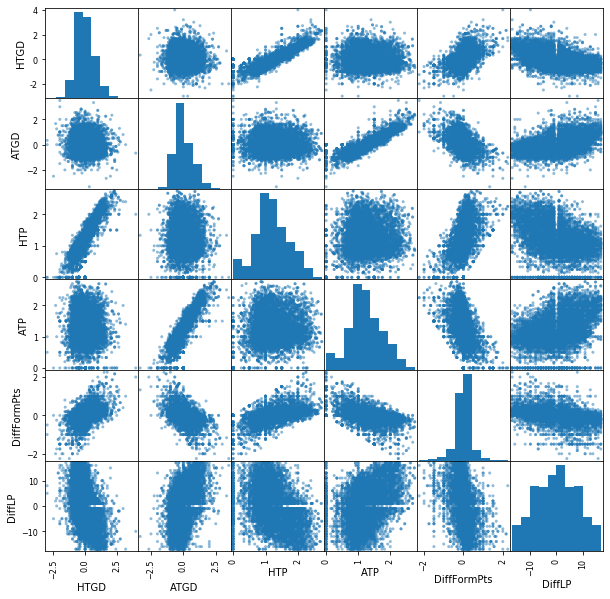

In [6]:
# 데이터의 분포를 시각화함
from pandas.plotting import scatter_matrix

scatter_matrix(data[['HTGD','ATGD','HTP','ATP','DiffFormPts','DiffLP']], figsize=(10,10))

In [7]:
# Feature와 각 경기의 x, y 축으로 나눔
X_all = data.drop(['FTR'],1)
y_all = data['FTR']

# 데이터 전처리
from sklearn.preprocessing import scale

cols = [['HTGD','ATGD','HTP','ATP','DiffLP']]
for col in cols:
    X_all[col] = scale(X_all[col])

In [8]:
# X_all, Y_all을 출력
print(X_all)

           HTP       ATP HM1 HM2 HM3 AM1 AM2 AM3      HTGD      ATGD  \
0    -2.247545 -2.323190   M   M   M   M   M   M  0.014827 -0.021544   
1    -2.247545 -2.323190   M   M   M   M   M   M  0.014827 -0.021544   
2    -2.247545 -2.323190   M   M   M   M   M   M  0.014827 -0.021544   
3    -2.247545 -2.323190   M   M   M   M   M   M  0.014827 -0.021544   
4    -2.247545 -2.323190   M   M   M   M   M   M  0.014827 -0.021544   
5    -2.247545 -2.323190   M   M   M   M   M   M  0.014827 -0.021544   
6    -2.247545 -2.323190   M   M   M   M   M   M  0.014827 -0.021544   
7    -2.247545 -2.323190   M   M   M   M   M   M  0.014827 -0.021544   
8    -2.247545 -2.323190   M   M   M   M   M   M  0.014827 -0.021544   
9    -2.247545 -2.323190   M   M   M   M   M   M  0.014827 -0.021544   
10   -2.247545  0.509731   L   M   M   W   M   M -0.685101  0.677642   
11   -2.247545  0.509731   L   M   M   W   M   M -0.685101  1.376829   
12   -2.247545  0.509731   L   M   M   W   M   M -1.385030  1.37

In [9]:
X_all.HM1 = X_all.HM1.astype('str')
X_all.HM2 = X_all.HM2.astype('str')
X_all.HM3 = X_all.HM3.astype('str')
X_all.AM1 = X_all.AM1.astype('str')
X_all.AM2 = X_all.AM2.astype('str')
X_all.AM3 = X_all.AM3.astype('str')

def preprocess_features(X):
    
    # 결과를 담을 데이터 초기화
    output = pd.DataFrame(index = X.index)

    # 데이터의 전체 에트리뷰트를 검사함
    for col, col_data in X.iteritems():

        # 만약 데이터가 카테고리형(범주형)인 경우
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # 새로운 출력 데이터 형식을 만듬
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (30 total features):
['HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_M', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_M', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_M', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_M', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_M', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_M', 'AM3_W', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP']


In [10]:
# 앞서 전처리 과정에서 추출된 데이터를 출력
print("\nFeature values:")
display(X_all.head())


Feature values:


,HTP,ATP,HM1_D,HM1_L,HM1_M,HM1_W,HM2_D,HM2_L,HM2_M,HM2_W,...,AM2_M,AM2_W,AM3_D,AM3_L,AM3_M,AM3_W,HTGD,ATGD,DiffFormPts,DiffLP
0,-2.247545,-2.32319,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0.014827,-0.021544,0.0,0.000000
1,-2.247545,-2.32319,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0.014827,-0.021544,0.0,-0.496237
2,-2.247545,-2.32319,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0.014827,-0.021544,0.0,0.248119
3,-2.247545,-2.32319,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0.014827,-0.021544,0.0,0.124059
4,-2.247545,-2.32319,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0.014827,-0.021544,0.0,-1.240593


In [11]:
from sklearn.model_selection import train_test_split

# 6300 개의 데이터를 training & test 로 나눔
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 50,
                                                    random_state = 47,
                                                    stratify = y_all)


## 모델 학습 및 검증

In [12]:
from time import time 
from sklearn.metrics import f1_score

# 학습 할 때 사용되는 분류기를 학습시킴 

def train_classifier(clf, X_train, y_train):
    
    # 시간 측정
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # 결과 시간 출력
    print ("Trained model in {:.4f} seconds".format(end - start))

# 승, 무, 패를 예측함
def predict_labels(clf, features, target):
    
    # 시간 측정
    start = time()
    
    # 분류기 내에서의 결과 예측
    y_pred = clf.predict(features)
    
    end = time()
    # 결과 시간 출력
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred, pos_label='H'), sum(target == y_pred) / float(len(y_pred))

#실제로 예측하는 함수

def train_predict(clf, X_train, y_train, X_test, y_test):
    
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
           
    # 분류기 학습
    train_classifier(clf, X_train, y_train)
    
    # 학습 데이터의 예측 결과를 저장 후 출력
    f1, acc = predict_labels(clf, X_train, y_train)
    print (f1, acc)
    print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    # 테스트 데이터의 예측 결과를 저장 후 출력       
    f1, acc = predict_labels(clf, X_test, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

In [13]:
# 3개의 모델에 집어넣음
# A : 로지스틱 회귀
# B : SVM
# C : XGBClassifier
# D, E, F, ... : CNN, RNN, LSTM, ...

model_A = LogisticRegression(random_state = 42)
model_B = SVC(random_state = 912, kernel='rbf')
model_C = xgb.XGBClassifier(seed = 82)

train_predict(model_A, X_train, y_train, X_test, y_test)
print ('')
train_predict(model_B, X_train, y_train, X_test, y_test)
print ('')
train_predict(model_C, X_train, y_train, X_test, y_test)
print ('')

# 이 데이터 셋에서는 XGB 분류기의 성능이 74% 정도로 가장 좋게 나옴

Training a LogisticRegression using a training set size of 6790. . .
Trained model in 0.0610 seconds
Made predictions in 0.0035 seconds.
0.626391617550753 0.6639175257731958
F1 score and accuracy score for training set: 0.6264 , 0.6639.
Made predictions in 0.0020 seconds.
F1 score and accuracy score for test set: 0.6667 , 0.6800.



C:\Users\user\.conda\envs\virtual_envs1\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training a SVC using a training set size of 6790. . .


C:\Users\user\.conda\envs\virtual_envs1\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Trained model in 5.4565 seconds
Made predictions in 2.8770 seconds.
0.6183008788557642 0.6737849779086893
F1 score and accuracy score for training set: 0.6183 , 0.6738.
Made predictions in 0.0240 seconds.
F1 score and accuracy score for test set: 0.5778 , 0.6200.

Training a XGBClassifier using a training set size of 6790. . .
Trained model in 1.7355 seconds
Made predictions in 0.0511 seconds.
0.6553389971680826 0.6952871870397643
F1 score and accuracy score for training set: 0.6553 , 0.6953.
Made predictions in 0.0020 seconds.
F1 score and accuracy score for test set: 0.6667 , 0.6800.



# XGBoost 모델에 넣어서 경기 결과 예측

In [16]:
#refered to this documentation : https://xgboost.readthedocs.io/en/latest/python/python_intro.html

# 하이퍼 파라미터
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
             }  

# 모델 객체 생성
model = xgb.XGBClassifier(seed=5506)

# scorer 함수를 만듬 (xgb 문서 참조)
f1_scorer = make_scorer(f1_score,pos_label='H')

# scorer 함수를 통해서 분류 객체를 생성
grid_obj = GridSearchCV(model,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

# 훈련 데이터에 grid model을 fitting시킴
grid_obj = grid_obj.fit(X_train,y_train)

# estimator를 모델에 추가
model = grid_obj.best_estimator_

# F1 score와 정확도 출력
f1, acc = predict_labels(model, X_train, y_train)
print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
f1, acc = predict_labels(model, X_test, y_test)
print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

# XGBoost의 성능이 72% 정도로 나옴

Made predictions in 0.0339 seconds.
F1 score and accuracy score for training set: 0.6350 , 0.6807.
Made predictions in 0.0025 seconds.
F1 score and accuracy score for test set: 0.6087 , 0.6400.


# GridSearch 모델에 넣어서 경기 결과 예측

In [17]:
# refered to this documentation https://scikit-learn.org/stable/modules/grid_search.html

# 하이퍼 파라메터
parameters = { 'learning_rate' : [0.03],
               'n_estimators' : [20],
               'max_depth': [5],
               'min_child_weight': [5],
               'gamma':[0.2],
               'subsample':[0.8],
               'colsample_bytree':[0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-2]
             }  

# 모델 객체 생성
clf = xgb.XGBClassifier(seed=5502)

# scorer 함수를 만듬 (문서 참조)
f1_scorer = make_scorer(f1_score,pos_label='H')

# scorer 함수를 통해서 분류 객체를 생성
grid_obj = GridSearchCV(clf,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

# 훈련 데이터에 grid model을 fitting시킴
grid_obj = grid_obj.fit(X_all,y_all)

# estimator
mymodel = grid_obj.best_estimator_
print (mymodel)

# F1 score와 정확도 출력
f1, acc = predict_labels(clf, X_train, y_train)
print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.2,
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=5502,
              silent=None, subsample=0.8, verbosity=1)


XGBoostError: need to call fit or load_model beforehand